# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from random import choice

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

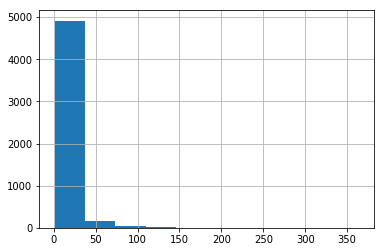

In [3]:
df.groupby(['email'])['article_id'].count().hist()

In [4]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby(['email'])['article_id'].count().median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby(['email'])['article_id'].count().max()# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
df_content[df_content.duplicated('article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [6]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id',keep='first', inplace = True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df.email.nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [8]:
article_count = pd.DataFrame(df.groupby('article_id')['email'].count()).reset_index()
article_count.iloc[article_count.email.idxmax()]

article_id    1429.0
email          937.0
Name: 699, dtype: float64

In [9]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    num_interaction_df = pd.DataFrame(df.groupby(['article_id','title'])['user_id'].count())
    num_interaction_df.columns = ['num_interaction']
    
    
    top_articles = list(num_interaction_df.sort_values(by='num_interaction',ascending=False)\
                        .reset_index()['title'][:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    num_interaction_df = pd.DataFrame(df.groupby('article_id')['user_id'].count())
    num_interaction_df.columns = ['num_interaction']
    top_articles = list(num_interaction_df.sort_values(by='num_interaction',ascending=False)\
                        .reset_index()['article_id'][:n])
    top_articles = list(map(str,top_articles))
    return top_articles # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = pd.pivot_table(df.drop(['title'],axis=1), index=['user_id'],aggfunc=lambda x:1,columns=['article_id'],fill_value=0 )
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    n_users = len(np.unique(df.user_id))
    
    user_sim = {}
    
    # compute similarity of each user to the provided user
    user_sim = user_item.dot(user_item.loc[user_id])
                          
    # sort by similarity
    user_sim = user_sim.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = user_sim.index.tolist()
    
    #remove the own_user's_id
    most_similar_users.remove(user_id)
    
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(np.unique(df[df.article_id.isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id]==1].index.values)
    
    
    article_names = get_article_names(article_ids,df)
    
    #article_ids = list(map(str,article_ids))
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    #list of users similar to the given user_id
    sim_users = find_similar_users(user_id, user_item)
    
    #list of articles seen by the user already
    articles_seen = get_user_articles(user_id)[0]
    
    recs = []
    
    #counter to keep check if m recommendations have been met
    
    count=0
    for user in sim_users:
        #get articles seen by the user
        articles_user = get_user_articles(user)[0]
        
        #loop through articles to give user recommendations of articles 
        #the user has not seen through similar users
        for article in articles_user:
            if(article not in articles_seen):
                if(count==m):
                    break
                recs.append(article)
                count = count+1
    
            
    return recs # return your recommendations for this user_id    

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'graph-based machine learning',
 'higher-order logistic regression for large datasets',
 'the 3 kinds of context: machine learning and the art of the frame',
 'this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'using brunel in ipython/jupyter notebooks',
 'using machine learning to predict parking difficulty']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user_sim = user_item.dot(user_item.loc[user_id])
    
    sim_df = user_sim.sort_values(ascending=False).drop(user_id).to_frame(name='similarity').reset_index()
    
    num_inter_df = df.user_id.value_counts().to_frame('num_interactions')
    
    neighbors_df = sim_df.merge(num_inter_df, left_on='user_id', right_index=True).rename(columns={'user_id':\
                                                                                                  'neighbor_id'})
    
    neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string

def articles_sorted_num_inter(article_ids):
    '''
    INPUT:
    article)ids - (list) a list of article_ids
     
    OUTPUT:
    article_ids_sorted - (list) a list of article ids sorted by number of interactions
    '''
    
    article_interaction_df = df.article_id.value_counts().to_frame('num_interactions').reset_index().\
    sort_values(by='num_interactions',ascending=False)
    
    article_ids_sorted = list(article_interaction_df[article_interaction_df.index.isin(article_ids)]['index'])
    
    return article_ids_sorted

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    #list of users similar to the given user_id
    sim_users= list(get_top_sorted_users(user_id)['neighbor_id'])
    
    #list of articles seen by the user already
    articles_seen = get_user_articles(user_id)[0]
    
    recs = []
    
    #counter to keep check if m recommendations have been met
    
    count=0
    for user in sim_users:
        #get articles seen by the user
        articles_user = get_user_articles(user)[0]
        
        #sort articles basis number of interactions in descending order
        articles_user = articles_sorted_num_inter(articles_user)
        
        #loop through articles to give user recommendations of articles 
        #the user has not seen through similar users
        for article in articles_user:
            if(article not in articles_seen):
                if(count==m):
                    break
                recs.append(article)
                count = count+1
            
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1437.0, 53.0, 221.0, 213.0, 1180.0, 76.0, 130.0, 749.0, 727.0, 965.0]

The top 10 recommendations for user 20 are the following article names:
['calls by customers of a telco company', 'data visualization playbook: revisiting the basics', "feature importance and why it's important", 'from python nested lists to multidimensional numpy arrays', 'how smart catalogs can turn the big data flood into an ocean of opportunity', 'hurricane how-to', 'introducing streams designer', 'modeling energy usage in new york city', 'this week in data science (may 2, 2017)', 'what caused the challenger disaster?']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
print(get_top_sorted_users(1).iloc[0]['neighbor_id'])
print(get_top_sorted_users(131).iloc[9]['neighbor_id'])

3933
242


In [25]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']# Find the 10th most similar user to user 131

In [26]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

Obviously we have no other data on a new user which is a classic case for Rank/Knowledge based recommendations. Our <b>get_top_article</b> function will come in handy for recommendations to new users.

Also, if we have meta data on our new users such as age, location etc. we may as well use <b>Content/Colloborative filterting Based Recommendations</b> by grouping users on meta data and finding out articles a particular groupd has most interacted with. This way, our new user will fall into one such group based on it's meta data, thereby providing some input to our Content/Colloborative filtering based recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [27]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [28]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

<p>As part of Content Based recommendations we need to find out article vs article similarity matrix. We'll be using nltk corpus and <b>TfIdfVectorizer</b> to construct the matrix using bag of words and compute similarity using <b>Cosine Similarity</b>.</p>


In [29]:
!pip install rake_nltk
!pip install progressbar

In [32]:
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from custom_transformer import CustomWord2Vec
import progressbar

## 1. Data Cleaning:

We'll clean the data create bag of words for each article in the dataframe. I have used <b>Rake</b> to extract key words out of the three columns. 

In [33]:
def data_cleaning(df=df_content):
    '''
    INPUT: 
    df -(pandas dataframe) dataframe defined at the top of the notebook containing information about articles
    
    OUTPUT: 
    df- (pandas dataframe) cleaned dataframe with one additional column Key_words
    
    '''
    
    #extraction of relevant columns for Keywords
    df = df[['doc_body','doc_description', 'doc_full_name','article_id']].set_index('article_id')
    
    #initializing the new column
    df['Key_words']=""
    
    for index, row in df.iterrows():
        doc_body = row['doc_body']
        doc_desc = row['doc_description']
        doc_full_name = row['doc_full_name']
        
        doc_final = str(doc_body)+str(doc_desc)+str(doc_full_name)

        # instantiating Rake, by default it uses english stopwords from NLTK
        # and discards all puntuation characters as well
        r = Rake()

        # extracting the words by passing the text
        r.extract_keywords_from_text(doc_final)

        # getting the dictionary with key words as keys and their scores as values
        key_words_dict_scores = r.get_word_degrees()
        
        key_words = []
        for x in key_words_dict_scores.keys():
            if x.isalpha() and len(x)>1:
                key_words.append(x) 
            
        # assigning the key words to the new column for the corresponding movie
        row['Key_words'] = ' '.join(map(str, key_words))
    
    return df


## 2. Modelling

In order to detect similarities between articles, vectorization is needed which will be done using <b>TfIdfVectorizer</b>. Then cosine similarities will be used to compute similarities

In [34]:
def compute_similarity(df=df_content):
    '''
    INPUT: 
    df -(pandas dataframe) dataframe defined at the top of the notebook containing information about articles
    
    OUTPUT: 
    cosine_sim- (array) returns a matrix of cosine similarities computed across articles
    
    '''
    
    df_clean = data_cleaning(df_content)
    
    #matrix computed using tfidf transformer
    vectorizer = TfidfVectorizer(analyzer='word',stop_words='english',ngram_range=(1,2),min_df=0)
    matrix_tfidf = vectorizer.fit_transform(df_clean['Key_words'])
    
    #fitting our corpus on Word2Vec custome transformer
    w2v =  CustomWord2Vec()
    w2v.fit(df_clean['Key_words'])
    matrix_w2v = w2v.transform(df_clean['Key_words'])
    
    #generating cosine similarity matrix using tfidf 
    cosine_sim_1 = cosine_similarity(matrix_tfidf,matrix_tfidf)
    
    #generating cosine similarity matrix using word2vec transformed matrix 
    cosine_sim_2 = cosine_similarity(matrix_w2v,matrix_w2v)
    
    #taking average of above two matrix to compute final similarity matrix
    cosine_sim = (cosine_sim_1+cosine_sim_2)/2
    
    return cosine_sim

In [35]:
#compute cosine similarities across articles
cosine_sim = compute_similarity(df_content)
cosine_sim

array([[1.        , 0.5001685 , 0.500358  , ..., 0.49936636, 0.49353501,
        0.4983431 ],
       [0.5001685 , 1.        , 0.50613053, ..., 0.51057504, 0.47421149,
        0.50523809],
       [0.500358  , 0.50613053, 1.        , ..., 0.50555951, 0.47614302,
        0.50127962],
       ...,
       [0.49936636, 0.51057504, 0.50555951, ..., 1.        , 0.47261606,
        0.50327044],
       [0.49353501, 0.47421149, 0.47614302, ..., 0.47261606, 1.        ,
        0.47456875],
       [0.4983431 , 0.50523809, 0.50127962, ..., 0.50327044, 0.47456875,
        1.        ]])

In [36]:
def find_similar_articles(article_id):
    '''
    INPUT
    article_id - a article_id 
    OUTPUT
    similar_articles - an array of the most similar articles 
    '''
    # find the row of each article_id
    article_idx = df_content[df_content.article_id==article_id].index.values[0]
    
    # find the most similar movie indices - to start I said they need to be the same for all content
    similar_indices = list(cosine_sim[article_idx].argsort()[:][::-1])
    
    #remove own_article index
    similar_indices.remove(article_idx)
    
    # pull the movie titles based on the indices
    similar_article = np.array(df_content.iloc[similar_indices, ]['article_id'].astype('float64'))
    
    return similar_article

In [37]:
#dataframe which store user_id, article_id and number of times user has interacted with article
user_art_num_inter = df.groupby(['user_id','article_id'])['article_id']\
.count().to_frame(name='num_article_inter').reset_index().sort_values(by='num_article_inter'\
                                                                      ,ascending=False)

In [38]:
# You made this function in an earlier notebook - using again here    
def get_article_names(article_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    article_lst = list(df_content[df_content['article_id'].isin(article_ids)]['doc_full_name'])
   
    return article_lst

def make_content_recs(user_id,df=df, df_content=df_content, num_rec=10):
    '''
    INPUT:
    
    OUTPUT:
    
    Other details: In content bases recommendation also we'll choose article which
                   user has interacted most with to find similar articles and then
                   proceed with other articles.
    
    '''
    #get list of articles seen by user already in order of most to least
    articles_seen = list(user_art_num_inter[user_art_num_inter.user_id==user_id]['article_id'])
    
    #unique article in df_content dataframe
    article_unique = list(df_content['article_id'].astype('float64').unique())
    
    #now there are various articles that were there in df dataframe but didn't exist in df_content
    #therefore we'll take intersection of only those articles
    articles_seen = list(set(articles_seen).intersection(set(article_unique)))
    
    #counter to keep track of no. of recommendations
    count=0
    rec=[]

    # Create the progressbar
    bar = progressbar.ProgressBar(maxval=num_rec, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    #get num_rec recommendations for user_id
    while(count!=num_rec):
        for article in articles_seen:
            if(count==num_rec):
                break
            most_sim_article = find_similar_articles(article)
            for art in most_sim_article:
                if(art not in articles_seen):
                    if(count==num_rec):
                        break
                    rec.append(art)
                    count=count+1
                    bar.update(count)
    
    # finish the progress bar
    bar.finish()
    
    rec_names = get_article_names(rec)
    
    return rec, rec_names

In [39]:
make_content_recs(203)

[========================================================================] 100%


([794.0, 645.0, 1006.0, 722.0, 162.0, 475.0, 482.0, 152.0, 51.0, 781.0],
 ['Modern Machine Learning Algorithms',
  'How to solve 90% of NLP problems',
  'An Introduction to Stock Market Data Analysis with R (Part 1)',
  'Gradient Boosting Explained',
  'Using Deep Learning With Keras To Predict Customer Churn',
  'How to Perform a Logistic Regression in R',
  'Visual Information Theory ',
  'Empirical Bayes for multiple sample sizes',
  'On calculating AUC',
  'Essentials of Machine Learning Algorithms (with Python and R Codes)'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

The content based recommender system lies solely on the basis of the articles similar to the one user has interacted with. Here's a summary of how the content based recommender system works.

<ol>1. Extraction of key words by merging <b>doc_full_name</b>, <b>doc_description</b> and <b>doc_body</b> columns from df_content dataframe</ol>
<ol>2. Vectorization using <b>TfIdfVectorizer</b> on the extracted keyword to compute normalized frequency and using <b>Word2Vec</b> model by gensim library to transform given corpus into vectors. </ol>
<ol>3. Computation of <b>cosine similarities</b> between articles based on TfIdf Vectorization and Word2Vec Transformation and taking average of 2.</ol>
<ol>4. Then for any given user, similar articles are generated basis cosine similarity. The article fed to compute most similar articles is the one which user has most interacted with</ol>

<p> <b>Note</b>: Our content based recommendation system, may yield better results if we use word embedding (e.g. spacy) to improve upon our similarity computation, but it's not always guaranteed.</p>
    

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
#below set of lines will find out user who has only interacted with article 1427
user_ids = list(df[(df.article_id==1427.0)]['user_id'])
user_id_1427=None
for user in user_ids:
    #print(df[(df.user_id==user)]['article_id'].nunique())
    if df[(df.user_id==user)]['article_id'].nunique()==1:
        user_id1427=user
        break
user_id_1427

In [41]:
# make recommendations for a brand new user
#content bases recommender cannot recommend for new user as it recommends articles basis user's existing choices

# make a recommendations for a user who only has interacted with article id '1427.0'(there are no such users)
make_content_recs(3910)



[========================================================================] 100%


([726.0, 1.0, 475.0, 40.0, 51.0, 871.0, 1006.0, 482.0, 152.0, 1030.0],
 ['Communicating data science: A guide to presenting your work',
  'Ensemble Learning to Improve Machine Learning Results',
  'Modern Machine Learning Algorithms',
  'How to solve 90% of NLP problems',
  'Gradient Boosting Explained',
  'Using Deep Learning With Keras To Predict Customer Churn',
  'May 2016: Scripts of the Week',
  'Overfitting in Machine Learning: What It Is and How to Prevent It',
  'Essentials of Machine Learning Algorithms (with Python and R Codes)',
  'Laplace noising versus simulated out of sample methods (cross frames)'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [42]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [43]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [44]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.**

Here we have populated the matrix on the foundation that if the user has interacted with the article the value will be 1 else 0. So, there is no chance of nan/missing values as there are only two possibilities for user article interaction. Consequently, the svd converges.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

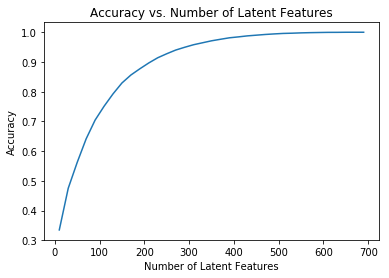

In [45]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [46]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [47]:
#How many users can we make predictions for in the test set?
common_idx_user = user_item_train.index.isin(test_idx)
print(common_idx_user.sum())

#How many users in the test set are we not able to make predictions for because of the cold start problem?
print(len(test_idx)-common_idx_user.sum())

#How many articles can we make predictions for in the test set?
common_idx_art = user_item_train.columns.isin(test_arts)
print(common_idx_art.sum())

#How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(len(test_arts)-common_idx_art.sum())

20
662
574
0


In [48]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict) 

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [49]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [53]:
u_test = u_train[common_idx_user, :]
vt_test = vt_train[:, common_idx_art]

print('Test Details: ',u_train.shape,vt_train.shape)
print('Test Details: ',u_test.shape,vt_test.shape)

Test Details:  (4487, 4487) (714, 714)
Test Details:  (20, 4487) (714, 574)


[3968, 3777, 4002, 3684, 4293, 2917, 4487, 4231, 3527, 4204, 3532, 3024, 4274, 3801, 3093, 3989, 3990, 3193, 3740, 3998]


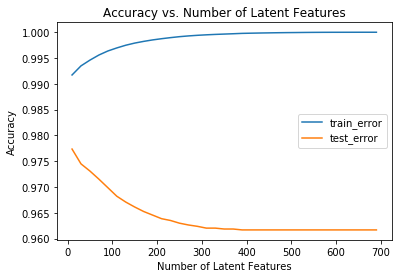

In [51]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
common_index = list(set(user_item_train.index).intersection(set(user_item_test.index)))
print(common_index)
user_item_test_subset = user_item_test.loc[common_index]

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_est)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    train_sum_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    test_sum_errs.append(test_err)
    
    
plt.plot(num_latent_feats, 1 - (np.array(train_sum_errs)/(user_item_train.shape[0]*user_item_train.shape[1])), label='train_error' );
plt.plot(num_latent_feats, 1 - (np.array(test_sum_errs)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])), label='test_error');
plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<p>Looking at the graph, we can see that increasing the number of latent features doesn't help, rather worsens situation in terms of accuracy. This is a classic case of overfitting. Although, it may also be attributed to the fact that there are only 20 users out 682 in the test dataset, for whom we can predict. It's a very low number and we may want to increase number of users in test dataset who do not fall in <b>cold start</b> category. The other thing we can do is to keep <b>less number of latent features</b></p>.

<p>Also, as the dataset is small, we cannot just resort to SVD for recommendations. We could use mix of Colloborative Filtering and Content Based Filtering to improve upon our recommendations as it happens in the real world. We design our cases with the combination of above recommendation techniques and conduct A/B testing to find out which holds best.And, to improve upon our SVD technique (and it will inherently benifit other techniques as well), collecting more features related to users and articles might help (e.g. time spent by the user on each article interacted, type of article, no. of search appearances for each article etc.).</p>

<p>Having said that, lets articulate our observations and answer few of the below questions.</p>

<ol><b>1. Is accuracy a good metric to use here in this case? Does it provide us with a fair assessment of the model's performance?</b> - We see that out of 682 test users, we could only predict for 20 users. Owing to this fact, accuracy may not be the correct metric for the assessment. Generally, <b>Mean Average Precsion (MAP)</b>is considered to be a better metric for recommender systems. It  gives insight into how relevant the list of recommended items are. However, we may also go for <b>Mean Average Recall (MAR)</b>. It gives insight into how well the recommender is able to recall all the items the user has rated positively in the test set.</ol> 
<ol><b>2. Is the current assessment framework robust enough to make conclusive results about the model? Think about the number of train and test users. How many users exist in your test set for whom you can make predictions? Is it sufficient?</b> - As stated previously, there are only 20 users for our test prediction. We want to test our accuracy on latent features ranging upto 700, so by a rule of thumb we would need 10-20 data points for each latent feature. Clearly our dataset is not enough to fulfill the requiement (Train_data - 4487, Test_data -20).</ol> 
<ol><b>3. How should we conduct our A/B testing to improve upon our recommendation model?</b> We will divide our userbase into Control and treatment groups by a <b>User_Id or Cookies</b> based diversion. User_Id is a stable choice as user has to login to view recommended articles. So <b>no_of_users or no_of_cookies</b> will be the <b>Invariant Metric</b>. As part of our Evaluation metric, strictly considering above scenarios, we can measure <b>no_of_recommended_article_clicked/no_of_users(or cookies)</b>.</ol>

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0